In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier

In [ ]:
old_bonds = pd.read_csv('../api/.cache2/bonds.csv')
old_etfs = pd.read_csv('../api/.cache2/etfs.csv')
old_shares = pd.read_csv('../api/.cache2/shares.csv')

new_bonds = pd.read_csv('../api/.cache/bonds.csv')
new_etfs = pd.read_csv('../api/.cache/etfs.csv')
new_shares = pd.read_csv('../api/.cache/shares.csv')

In [ ]:
old_bonds.columns

In [ ]:
valid_columns = list(set(old_bonds.columns) & set(old_etfs.columns) & set(old_shares.columns))

In [ ]:
old_bonds = old_bonds[valid_columns]
old_etfs = old_etfs[valid_columns]
old_shares = old_shares[valid_columns]

In [ ]:
old_bonds = old_bonds.dropna()
old_etfs = old_etfs.dropna()
old_shares = old_shares.dropna()

In [ ]:
useless_columns = [
    "ticker", "rub_price", "name", "company_rating", "isin", "price_rating", "ratings", "price", "country_of_risk_name"
]

old_bonds = old_bonds.drop(useless_columns, axis=1)
old_etfs = old_etfs.drop(useless_columns, axis=1)
old_shares = old_shares.drop(useless_columns, axis=1)

In [ ]:
list(old_bonds.columns) == list(old_etfs.columns) == list(old_shares.columns)

In [ ]:
train = pd.concat([old_bonds, old_etfs, old_shares])

In [ ]:
new_bonds = new_bonds[valid_columns].drop(useless_columns, axis=1)
new_etfs = new_etfs[valid_columns].drop(useless_columns, axis=1)
new_shares = new_shares[valid_columns].drop(useless_columns, axis=1)

val = pd.concat([new_bonds, new_etfs, new_shares])

In [ ]:
val[["candle_price", "figi"]].rename({"candle_price": "price"}, axis=1)

In [ ]:
import numpy as np

train.loc[np.isin(train.figi, val.figi)].shape == train.shape

In [ ]:
train = train.loc[np.isin(train.figi, val.figi)]

In [ ]:
prices = pd.merge(
    val[["candle_price", "figi"]].rename({"candle_price": "price"}, axis=1), train[["candle_price",
                                                                                    "figi"]],
    on="figi",
    how="left"
)

In [ ]:
na_figis = prices[prices.isna()].figi

In [ ]:
prices = prices.dropna()

In [ ]:
prices["target"] = prices.price > prices.candle_price

In [ ]:
prices.dtypes

In [ ]:
train["target"] = train.figi.apply(lambda x: prices.loc[prices.figi == x].iloc[0].target)

In [ ]:
train = train.drop(["figi", "candle_price"], axis=1)

In [ ]:
train.columns

In [ ]:
train.dtypes

In [ ]:
real_bonds = pd.read_csv('../api/.actual_cache/bonds.csv')
real_etfs = pd.read_csv('../api/.actual_cache/etfs.csv')
real_shares = pd.read_csv('../api/.actual_cache/shares.csv')

In [ ]:
real_bonds = real_bonds[valid_columns].drop(useless_columns, axis=1)
real_etfs = real_etfs[valid_columns].drop(useless_columns, axis=1)
real_shares = real_shares[valid_columns].drop(useless_columns, axis=1)

In [ ]:
test = pd.concat([real_bonds, real_etfs, real_shares])

In [ ]:
test = test.dropna()

In [ ]:
val.figi.nunique(), test.figi.nunique()

In [ ]:
test_prices = pd.merge(
    test[["candle_price", "figi"]].rename({"candle_price": "price"}, axis=1), val[["candle_price", "figi"]],
    on="figi",
    how="left"
)

In [ ]:
test_prices = test_prices.dropna()
test_prices["target"] = test_prices.price > test_prices.candle_price
X_test = val.loc[np.isin(val.figi, test.figi)]
Y_test = X_test.figi.apply(lambda x: test_prices.loc[test_prices.figi == x].iloc[0].target)

In [ ]:
X_test = X_test.drop(["figi", "candle_price"], axis=1)

In [250]:
model = CatBoostClassifier(iterations=10001, depth=5)

In [251]:
model.fit(
    train.drop("target", axis=1),
    train.target,
    verbose=100,
    cat_features=[
        "currency",
        "country_of_risk",
        "exchange",
        "class_code",
        "sector"
    ]
)

Learning rate set to 0.001393
0:	learn: 0.6928123	total: 12.2ms	remaining: 2m 1s
100:	learn: 0.6662781	total: 194ms	remaining: 19s
200:	learn: 0.6449033	total: 363ms	remaining: 17.7s
300:	learn: 0.6277406	total: 542ms	remaining: 17.5s
400:	learn: 0.6135756	total: 729ms	remaining: 17.5s
500:	learn: 0.6020645	total: 909ms	remaining: 17.2s
600:	learn: 0.5928085	total: 1.09s	remaining: 17s
700:	learn: 0.5847055	total: 1.27s	remaining: 16.9s
800:	learn: 0.5776791	total: 1.45s	remaining: 16.7s
900:	learn: 0.5719739	total: 1.63s	remaining: 16.5s
1000:	learn: 0.5668953	total: 1.82s	remaining: 16.4s
1100:	learn: 0.5622258	total: 2s	remaining: 16.2s
1200:	learn: 0.5584656	total: 2.18s	remaining: 16s
1300:	learn: 0.5547438	total: 2.37s	remaining: 15.9s
1400:	learn: 0.5515246	total: 2.56s	remaining: 15.7s
1500:	learn: 0.5485183	total: 2.75s	remaining: 15.6s
1600:	learn: 0.5458630	total: 2.94s	remaining: 15.5s
1700:	learn: 0.5432636	total: 3.14s	remaining: 15.3s
1800:	learn: 0.5410220	total: 3.33s	

In [252]:
from sklearn.metrics import classification_report

In [253]:
print(classification_report(Y_test.astype(str), model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.83      0.77      0.80      1004
        True       0.40      0.48      0.44       313

    accuracy                           0.70      1317
   macro avg       0.61      0.63      0.62      1317
weighted avg       0.73      0.70      0.71      1317



In [ ]:
bonds = pd.read_csv('../api/.cache/bonds.csv')
etfs = pd.read_csv('../api/.cache/etfs.csv')
shares = pd.read_csv('../api/.cache/shares.csv')

In [255]:
bonds_nans = bonds[X_test.columns].isna().any(axis=1)

In [256]:
score = model.predict_proba(bonds[X_test.columns][~bonds_nans])

In [257]:
bonds.loc[~bonds_nans, "ratings"] = score[:, 1]
bonds.loc[bonds_nans, "ratings"] = 0

In [258]:
bonds

,figi,ticker,class_code,isin,currency,name,exchange,coupon_quantity_per_year,maturity_date,nominal,...,company_rating,mean_return,stability,inverse_drawdown,sharpe_ratio,sortino_ratio,trend_slope,price_rating,ratings,candle_price
0,TCS00A107D74,RU000A107D74,TQCB,RU000A107D74,rub,ЭнергоТехСервис 001P-05,MOEX,12,02/12/2025,1000.00,...,6.293961,5.478607,7.072402,2.321849,5.604616,5.315462,4.959775,5.125452,0.231805,96.05
1,BBG00XH4W3N3,RU000A101RZ3,TQCB,RU000A101RZ3,rub,Казахстан выпуск 11,MOEX,2,11/09/2030,1000.00,...,3.675523,2.037783,6.312588,6.928665,2.235709,2.225757,2.040463,3.630161,0.013706,59.56
2,BBG00Z8KGGC3,RU000A102R73,TQCB,RU000A102R73,rub,Банк Открытие БО-П выпуск 7,MOEX,2,06/02/2026,1000.00,...,5.425456,2.576455,0.000000,9.113294,6.559297,6.287767,0.008493,4.090884,0.306771,77.83
3,TCS00A102D46,RU000A102D46,TQCB,RU000A102D46,rub,ДОМ.РФ ИА 018P,MOEX,4,28/02/2051,380.15,...,5.401428,2.167806,4.603457,7.343594,3.974293,4.113328,1.809578,4.002009,0.123528,68.05
4,ISSUANCEPRLS,RU000A1022E6,TQCB,RU000A1022E6,rub,ПР-Лизинг 002P-01,MOEX,12,10/08/2029,1000.00,...,6.306879,6.437097,7.994501,1.562965,6.717169,6.388216,6.236490,5.889406,0.482279,95.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,TCS00A105Q63,RU000A105Q63,TQCB,RU000A105Q63,rub,Уральская Сталь выпуск 1,MOEX,2,25/12/2025,1000.00,...,4.992343,5.023308,5.829206,2.719374,5.775431,5.498220,5.150632,4.999362,0.203010,88.60
1093,BBG012YS2TP2,RU000A103VD8,TQCB,RU000A103VD8,rub,МСБ-Лизинг 002P выпуск 5,MOEX,12,18/09/2026,638.86,...,6.204105,5.257028,5.383971,2.627258,6.155981,5.912684,5.499200,5.139354,0.295340,91.28
1094,TCS00A105HJ9,RU000A105HJ9,TQCB,RU000A105HJ9,rub,Альфа-Банк 002Р-18,MOEX,2,29/11/2024,1000.00,...,5.442307,6.950916,8.011526,0.537598,7.731825,7.442248,7.035189,6.284884,0.578111,99.09
1095,TCS00A104735,RU000A104735,TQCB,RU000A104735,rub,ГК Пионер-001P выпуск 6,MOEX,4,04/12/2025,1000.00,...,4.801130,5.907525,7.932433,1.360698,5.726598,5.075679,5.807311,5.301707,0.499176,92.30


In [259]:
shares_nans = shares[X_test.columns].isna().any(axis=1)
score = model.predict_proba(shares[X_test.columns][~shares_nans])
shares.loc[~shares_nans, "ratings"] = score[:, 1]
shares.loc[shares_nans, "ratings"] = 0

In [260]:
shares

,figi,ticker,class_code,isin,currency,name,exchange,ipo_date,nominal,issue_size,...,company_rating,mean_return,stability,inverse_drawdown,sharpe_ratio,sortino_ratio,trend_slope,price_rating,ratings,candle_price
0,TCS007940839,KZIZP,MTQR,RU0007940839,rub,Красногорский завод им. С.А. Зверева - привилегированные акции,otc_ncc,12/10/2007,0.10,1343020,...,3.708377,0.000000,2.288596,10.000000,1.225197,1.263783,0.111665,2.481540,0.697769,302.990000
1,TCS00A108ZR8,DATA,TQBR,RU000A108ZR8,rub,Группа Аренадата,moex_extended,15/04/2024,0.05,200000000,...,7.724214,10.000000,8.014655,0.000000,8.890543,9.193300,10.000000,7.683083,0.588578,111.380000
2,BBG000FWGSZ5,IRKT,TQBR,RU0006752979,rub,Яковлев,MOEX_DEALER_WEEKEND,15/08/2002,3.00,12051279624,...,9.611296,3.251468,2.911034,8.364985,3.593304,3.334751,2.541478,3.999504,0.759401,43.550000
3,BBG004S68CV8,VSMO,TQBR,RU0009100291,rub,ВСМПО-АВИСМА,MOEX_DEALER_WEEKEND,11/11/2004,1.00,11529538,...,6.693208,2.328148,5.884966,5.291744,2.560762,2.241224,2.903713,3.535093,0.756340,26580.000000
4,BBG000Q7ZZY2,UNAC,TQBR,RU000A0JPLZ7,rub,Объединенная авиастроительная корпорация,MOEX_DEALER_WEEKEND,26/04/2013,0.27,994436434417,...,9.802516,2.025850,3.348198,10.000000,2.850808,2.415672,0.000000,3.440088,0.883707,0.771000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,BBG004S68BR5,NMTP,TQBR,RU0009084446,rub,НМТП,MOEX_DEALER_WEEKEND,04/06/2003,0.01,19259815400,...,9.625636,2.253016,5.589684,4.732105,2.574496,2.618918,2.607009,3.395871,0.857210,8.495000
169,BBG000QFH687,TGKA,TQBR,RU000A0JNUD0,rub,ТГК-1,MOEX_DEALER_WEEKEND,17/05/2005,0.01,3854341416571,...,9.660532,2.164127,7.057391,3.701367,1.966651,1.731214,2.925508,3.257710,0.878465,0.007204
170,BBG0027F0Y27,CNTLP,TQBR,RU0007665139,rub,Центральный Телеграф - акции привилегированные,moex_extended,20/12/2002,1.00,55389000,...,3.818459,2.471787,6.063629,4.820033,2.640975,2.469703,2.557676,3.503967,0.879370,8.400000
171,BBG004S68FR6,MTLRP,TQBR,RU000A0JPV70,rub,Мечел - Привилегированные акции,MOEX_DEALER_WEEKEND,05/06/2008,10.00,138756915,...,7.218503,0.000000,5.298516,10.000000,0.000000,0.000000,0.000000,2.549753,0.889221,111.450000


In [261]:
etfs_nans = etfs[X_test.columns].isna().any(axis=1)
score = model.predict_proba(etfs[X_test.columns][~etfs_nans])
etfs.loc[~etfs_nans, "ratings"] = score[:, 1]
etfs.loc[etfs_nans, "ratings"] = 0

In [262]:
bonds["ratings"] = bonds["ratings"] * 1000
shares["ratings"] = shares["ratings"] * 1000
etfs["ratings"] = etfs["ratings"] * 1000

In [263]:
bonds.to_csv('../api/.cache/bonds.csv', index=False)
shares.to_csv('../api/.cache/shares.csv', index=False)
etfs.to_csv('../api/.cache/etfs.csv', index=False)

In [ ]:
model.get_feature_importance()

In [ ]:
pd.DataFrame({"column": X_test.columns, "importance": model.get_feature_importance()})

In [ ]:
num_columns = train

In [176]:
indexes = (train.drop("target", axis=1).dtypes != "object")

In [197]:
num_columns = indexes[indexes.values].index.values

In [265]:
from sklearn.linear_model import LogisticRegressionCV

In [266]:
model2 = LogisticRegressionCV()

In [267]:
model2.fit(train[num_columns], train["target"])

LogisticRegressionCV()

In [268]:
bonds_nans = bonds[X_test.columns].isna().any(axis=1)
pred = bonds[list(set(X_test.columns) & set(num_columns))][~bonds_nans]
pred = pred.reindex(columns=num_columns)
score = model2.predict_proba(pred)
bonds.loc[~bonds_nans, "ratings"] = score[:, 1] * 1000
bonds.loc[bonds_nans, "ratings"] = 0

In [269]:
shares_nans = shares[X_test.columns].isna().any(axis=1)
pred = shares[list(set(X_test.columns) & set(num_columns))][~shares_nans]
pred = pred.reindex(columns=num_columns)
score = model2.predict_proba(pred)
shares.loc[~shares_nans, "ratings"] = score[:, 1] * 1000
shares.loc[shares_nans, "ratings"] = 0

In [270]:
etfs_nans = etfs[X_test.columns].isna().any(axis=1)
pred = etfs[list(set(X_test.columns) & set(num_columns))][~etfs_nans]
pred = pred.reindex(columns=num_columns)
score = model2.predict_proba(pred)
etfs.loc[~etfs_nans, "ratings"] = score[:, 1] * 1000
etfs.loc[etfs_nans, "ratings"] = 0

In [271]:
bonds.to_csv('../api/.cache/bonds.csv', index=False)
shares.to_csv('../api/.cache/shares.csv', index=False)
etfs.to_csv('../api/.cache/etfs.csv', index=False)

In [272]:
print(model2.get_params())

{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}


In [223]:
preds = X_test[list(set(X_test.columns) & set(num_columns))]
preds = preds.reindex(columns=num_columns)
preds = model2.predict(preds)

In [224]:
Y_test.shape, preds.shape

((1317,), (1317,))

In [226]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

       False       0.76      0.99      0.86      1004
        True       0.00      0.00      0.00       313

    accuracy                           0.76      1317
   macro avg       0.38      0.50      0.43      1317
weighted avg       0.58      0.76      0.66      1317



([<matplotlib.patches.Wedge at 0x16c1b7310>,
 [Text(-0.8073761396725034, 0.7470902014399107, 'False'),
  Text(0.8073761046986861, -0.7470902392359148, 'True')])

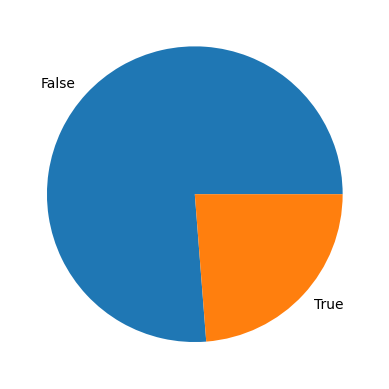

In [231]:
import matplotlib.pyplot as plt
plt.pie(Y_test.value_counts(), labels=Y_test.value_counts().index)

In [241]:
print(classification_report(Y_test.astype(str), model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.83      0.78      0.80      1004
        True       0.40      0.47      0.43       313

    accuracy                           0.71      1317
   macro avg       0.61      0.62      0.62      1317
weighted avg       0.72      0.71      0.71      1317



In [254]:
print(classification_report(train.target.astype(str), model.predict(train.drop("target", axis=1))))

              precision    recall  f1-score   support

       False       0.80      0.90      0.85       803
        True       0.80      0.63      0.70       492

    accuracy                           0.80      1295
   macro avg       0.80      0.76      0.77      1295
weighted avg       0.80      0.80      0.79      1295

